In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from itertools import combinations
from scipy.stats import chi2_contingency
# Otros objetivos
# -----------------------------------------------------------------------
import math
# Funciones
import sys
sys.path.append('../../') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f
import src.soporte_prep as spp

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Outliers
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors 

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_pickle('../../Datos_Mod3/datos_iterative.pkl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      1573 non-null   int64   
 1   Attrition                1573 non-null   int64   
 2   BusinessTravel           1573 non-null   object  
 3   Department               1573 non-null   object  
 4   DistanceFromHome         1573 non-null   int64   
 5   Education                1573 non-null   category
 6   EducationField           1573 non-null   object  
 7   Gender                   1573 non-null   object  
 8   JobLevel                 1573 non-null   category
 9   JobRole                  1573 non-null   object  
 10  MaritalStatus            1573 non-null   object  
 11  MonthlyIncome            1573 non-null   float64 
 12  NumCompaniesWorked       1573 non-null   float64 
 13  PercentSalaryHike        1573 non-null   int64   
 14  StockOpt

In [5]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,1482.108,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,473.357,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,2184.064,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,940.273,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,264.646,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [6]:
visuales = spp.Visualizador(df)

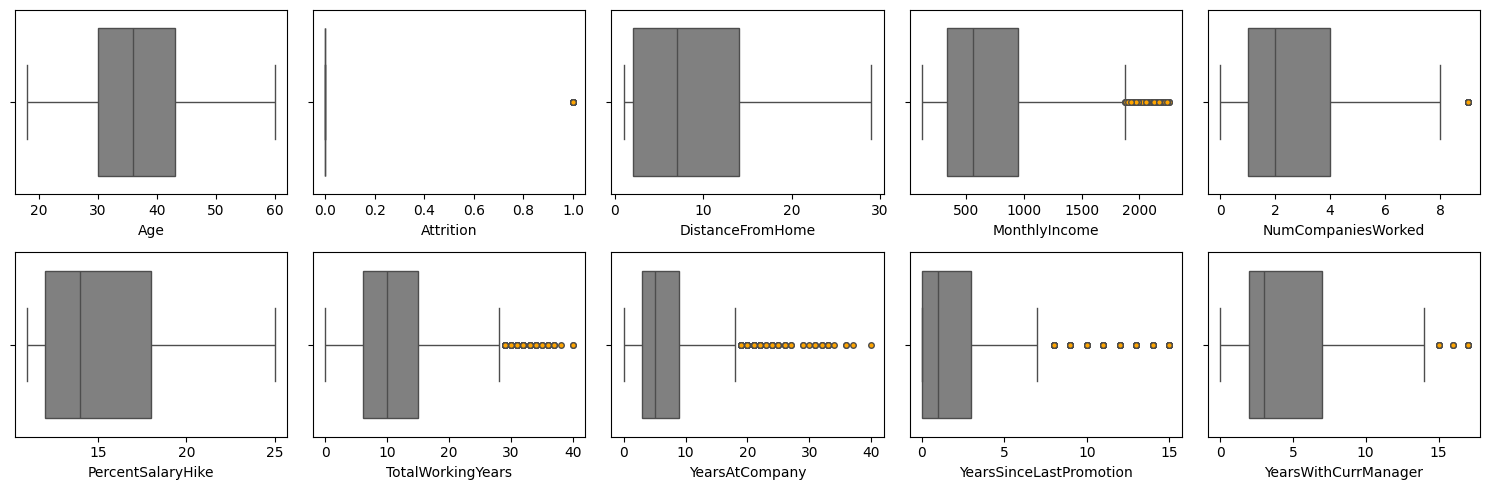

In [7]:
visuales.deteccion_outliers()

## Outliers univariados:
- Por encima de los 160,000 se observan una serie de univariados que destancan como outliers.
- En los años totales de trabajo, por encima de los 30 años se presentan los outliers.
- Casi al llegar los 20 años en la compañia, esos datos se presentan como outliers.
- Poco después de los 5 años sin recibir una promoción, estas personas que se encuentran en este segmento mayor parecen ser outliers.
- Después de 15 años bajo el mismo gerente, parecen ser outliers también.

In [8]:
contaminacion = [0.01, 0.05, 0.1]
vecinos = [15,25,35]

In [9]:
combinaciones_lof = list(product(contaminacion, vecinos))
combinaciones_lof

[(0.01, 15),
 (0.01, 25),
 (0.01, 35),
 (0.05, 15),
 (0.05, 25),
 (0.05, 35),
 (0.1, 15),
 (0.1, 25),
 (0.1, 35)]

In [10]:
cols_num = df.select_dtypes([int, float]).columns

In [11]:
cols_num

Index(['Age', 'Attrition', 'DistanceFromHome', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [12]:
for cont, vec in tqdm(combinaciones_lof):
    lof = LocalOutlierFactor(n_neighbors=vec, #semilla de datos aleatorios
                        algorithm='auto',
                        contamination=cont,
                        n_jobs=-1) #nucleos del ordenador

    df[f'outliers_lof_{cont}_{vec}'] = lof.fit_predict(df[['Age', 'DistanceFromHome', 'MonthlyIncome','NumCompaniesWorked',
                                                                     'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany','YearsSinceLastPromotion',
                                                                       'YearsWithCurrManager']])

100%|██████████| 9/9 [00:00<00:00, 43.00it/s]


In [13]:
columnas_lof = df.filter(like='outlier').columns 
columnas_lof

Index(['outliers_lof_0.01_15', 'outliers_lof_0.01_25', 'outliers_lof_0.01_35',
       'outliers_lof_0.05_15', 'outliers_lof_0.05_25', 'outliers_lof_0.05_35',
       'outliers_lof_0.1_15', 'outliers_lof_0.1_25', 'outliers_lof_0.1_35'],
      dtype='object')

In [14]:
combinaciones_lof

[(0.01, 15),
 (0.01, 25),
 (0.01, 35),
 (0.05, 15),
 (0.05, 25),
 (0.05, 35),
 (0.1, 15),
 (0.1, 25),
 (0.1, 35)]

In [15]:
filtered_df = df[(df[columnas_lof] == -1).all(axis=1)]

In [16]:
df.describe()

,Age,Attrition,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,outliers_lof_0.01_15,outliers_lof_0.01_25,outliers_lof_0.01_35,outliers_lof_0.05_15,outliers_lof_0.05_25,outliers_lof_0.05_35,outliers_lof_0.1_15,outliers_lof_0.1_25,outliers_lof_0.1_35
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,36.904005,0.160203,9.158296,734.267894,2.684679,15.202161,11.229498,6.970757,2.184361,4.102988,0.979657,0.979657,0.979657,0.899555,0.899555,0.899555,0.799110,0.799110,0.799110
std,9.105911,0.366911,8.124414,532.475654,2.500076,3.646403,7.730600,6.068348,3.203105,3.572701,0.200745,0.200745,0.200745,0.436946,0.436946,0.436946,0.601376,0.601376,0.601376
min,18.000000,0.000000,1.000000,114.017000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,30.000000,0.000000,2.000000,327.587000,1.000000,12.000000,6.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,36.000000,0.000000,7.000000,553.700000,2.000000,14.000000,10.000000,5.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,43.000000,0.000000,14.000000,946.940000,4.000000,18.000000,15.000000,9.000000,3.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,60.000000,1.000000,29.000000,2259.887000,9.000000,25.000000,40.000000,40.000000,15.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
filtered_df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,outliers_lof_0.01_15,outliers_lof_0.01_25,outliers_lof_0.01_35,outliers_lof_0.05_15,outliers_lof_0.05_25,outliers_lof_0.05_35,outliers_lof_0.1_15,outliers_lof_0.1_25,outliers_lof_0.1_35
260,38,0,Travel_Rarely,Research & Development,16,3,Life Sciences,Male,5,Research Scientist,Single,1667.428,0.0,20,1,8.0,3,7,0,5,4.0,4.0,3.0,2,4,-1,-1,-1,-1,-1,-1,-1,-1,-1
656,55,0,Non-Travel,Research & Development,27,3,Life Sciences,Female,2,Manager,Divorced,549.067,1.0,24,1,34.0,3,33,15,0,4.0,2.0,3.0,4,4,-1,-1,-1,-1,-1,-1,-1,-1,-1
729,51,0,Travel_Frequently,Research & Development,20,3,Medical,Male,2,Sales Executive,Married,1673.982,2.0,11,1,14.0,2,4,3,2,2.0,2.0,3.0,2,3,-1,-1,-1,-1,-1,-1,-1,-1,-1
896,47,0,Travel_Rarely,Research & Development,25,4,Medical,Male,2,Research Scientist,Married,1678.276,3.0,19,3,27.0,3,5,1,0,4.0,3.0,3.0,2,3,-1,-1,-1,-1,-1,-1,-1,-1,-1
1205,31,0,Non-Travel,Research & Development,8,4,Life Sciences,Female,4,Sales Executive,Single,1664.716,0.0,12,0,10.0,3,9,1,7,2.0,1.0,3.0,3,3,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [18]:
df_sin_out = df[~df.index.isin(filtered_df.index)] # aqui me quito los outliers al 100% multivariados

In [19]:
df_sin_out.shape

(1568, 34)

In [20]:
fragmento = 0.6 * len(columnas_lof)
df_fragmento_60 = df_sin_out[df_sin_out[columnas_lof].eq(-1).sum(axis=1) >= fragmento]

In [21]:
df_fragmento_60

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,outliers_lof_0.01_15,outliers_lof_0.01_25,outliers_lof_0.01_35,outliers_lof_0.05_15,outliers_lof_0.05_25,outliers_lof_0.05_35,outliers_lof_0.1_15,outliers_lof_0.1_25,outliers_lof_0.1_35
12,55,0,Travel_Rarely,Research & Development,14,4,Life Sciences,Female,1,Sales Executive,Single,625.794,0.0,17,0,37.0,2,36,4,13,4.0,1.0,3.0,3,3,-1,-1,1,-1,-1,-1,-1,-1,-1
163,29,1,Travel_Rarely,Research & Development,19,4,Life Sciences,Male,3,Research Scientist,Married,202.270,5.0,16,1,6.0,4,2,1,1,3.0,2.0,4.0,2,3,1,-1,1,-1,-1,-1,-1,-1,-1
167,50,0,Travel_Rarely,Sales,10,4,Life Sciences,Female,3,Manager,Married,540.931,0.0,12,0,28.0,3,27,15,7,2.0,3.0,3.0,3,3,1,1,1,-1,-1,-1,-1,-1,-1
215,49,0,Travel_Rarely,Sales,21,1,Life Sciences,Male,1,Sales Executive,Divorced,453.243,1.0,18,2,31.0,2,31,0,9,4.0,3.0,3.0,1,3,-1,1,1,-1,-1,-1,-1,-1,-1
303,52,0,Travel_Rarely,Sales,21,5,Technical Degree,Male,3,Manager,Married,326.457,1.0,11,1,34.0,2,34,1,16,3.0,1.0,4.0,3,3,1,1,1,-1,-1,-1,-1,-1,-1
322,35,0,Travel_Rarely,Research & Development,5,4,Medical,Male,3,Manager,Married,189.275,1.0,16,0,3.0,6,3,0,2,1.0,4.0,2.0,2,3,1,-1,-1,1,-1,-1,1,-1,-1
337,58,1,Travel_Rarely,Research & Development,24,3,Other,Female,2,Research Scientist,Single,487.821,7.0,17,0,40.0,2,31,13,8,4.0,2.0,3.0,3,3,1,-1,1,-1,-1,-1,-1,-1,-1
395,50,0,Non-Travel,Research & Development,17,3,Medical,Female,1,Laboratory Technician,Divorced,485.674,1.0,20,1,31.0,6,31,14,7,1.0,1.0,3.0,3,4,1,1,1,-1,-1,-1,-1,-1,-1
408,22,1,Travel_Rarely,Research & Development,15,4,Life Sciences,Female,1,Laboratory Technician,Married,1411.370,0.0,13,0,4.0,3,3,0,2,2.0,3.0,4.0,3,3,1,1,1,-1,-1,-1,-1,-1,-1
431,20,1,Travel_Rarely,Research & Development,29,3,Life Sciences,Female,3,Laboratory Technician,Single,305.891,1.0,11,0,1.0,2,1,0,0,1.0,1.0,3.0,3,3,-1,1,1,-1,-1,-1,-1,-1,-1


Aquí vemos outliers que pueden ser bastante llamativos, más si consideramos los salarios y los niveles educativos de estos.

In [22]:
df_sin_out.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,outliers_lof_0.01_15,outliers_lof_0.01_25,outliers_lof_0.01_35,outliers_lof_0.05_15,outliers_lof_0.05_25,outliers_lof_0.05_35,outliers_lof_0.1_15,outliers_lof_0.1_25,outliers_lof_0.1_35
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,1482.108,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,1,1,1,1,1,1,1,1,1
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,473.357,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,1,1,1,1,1,1,1,1,1
2,32,0,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,2184.064,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,1,1,1,1,1,1,1,1,1
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,940.273,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,1,1,1,1,1,1,1,1,1
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,264.646,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,1,1,1,1,1,1,1,1,1


In [23]:
df_sin_out.shape

(1568, 34)

In [24]:
df_sin_out.drop(columns=columnas_lof, inplace=True)

In [25]:
df_sin_out.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,1482.108,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,473.357,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,2184.064,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,940.273,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,264.646,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [26]:
df_sin_out.to_pickle('../../Datos_Mod3/df_sin_out.pkl')